In [2]:
!pip install pandas

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 21.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.9/507.9 kB 142.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.8/346.8 kB 125.0 MB/s eta 0:00:00


In [3]:
!pip install numpy

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [4]:
!pip install matplotlib

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [5]:
!pip install seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.5 MB/s eta 0:00:00a 0:00:01


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (adjust the path if needed)
df = pd.read_csv(r'autodl-tmp/AAC concrete dataset large ratio.csv')
print("Dataset head:")
print(df.head())


Dataset head:
  Idx_Sample Ref. Mixture Code in Ref   SiO2  Al2O3  Fe2O3   CaO   MgO  Na2O  \
0          1  [2]                FA-I  53.36  26.49  10.86  1.34  0.77  0.37   
1          2  [2]                FA-I  53.36  26.49  10.86  1.34  0.77  0.37   
2          3  [2]                FA-I  53.36  26.49  10.86  1.34  0.77  0.37   
3          4  [2]                FA-I  53.36  26.49  10.86  1.34  0.77  0.37   
4          5  [2]                FA-I  53.36  26.49  10.86  1.34  0.77  0.37   

   K2O  ...  14-d Cylindrical compressive strength (MPa)  \
0  0.8  ...                                          NaN   
1  0.8  ...                                          NaN   
2  0.8  ...                                          NaN   
3  0.8  ...                                          NaN   
4  0.8  ...                                          NaN   

   21-d Cylindrical compressive strength (MPa)  \
0                                          NaN   
1                                          N


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1630 entries, 0 to 1629
Data columns (total 76 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   Idx_Sample                                                                             1630 non-null   object 
 1   Ref.                                                                                   1630 non-null   object 
 2   Mixture Code in Ref                                                                    1534 non-null   object 
 3   SiO2                                                                                   1630 non-null   float64
 4   Al2O3                                                                                  1630 non-null   float64
 5   Fe2O3                                                        

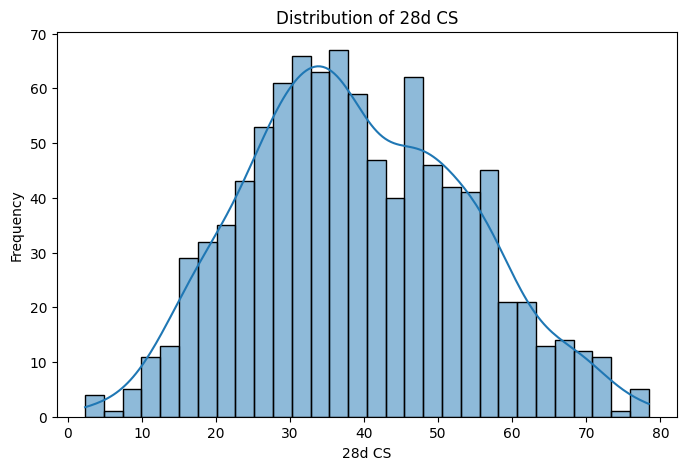

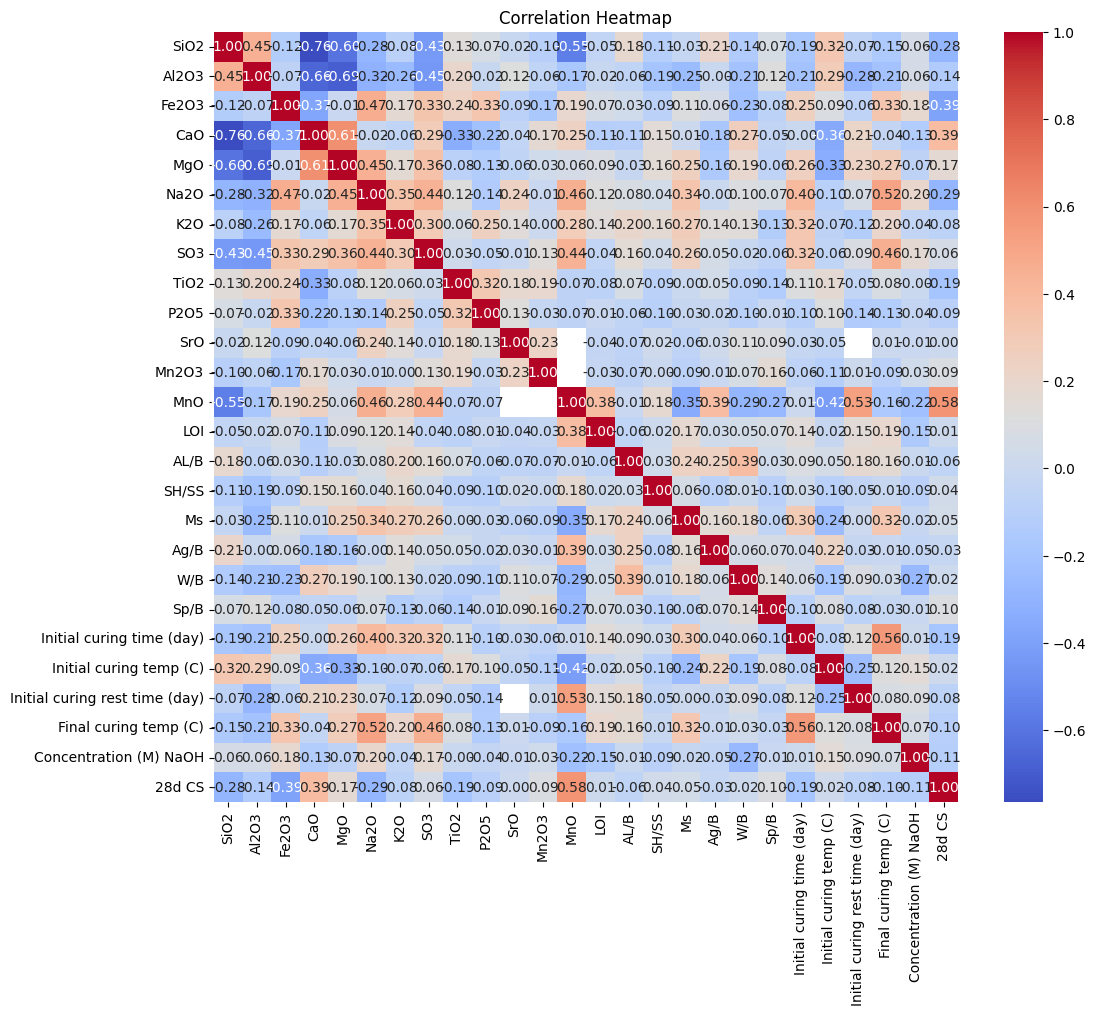

In [46]:
# Overview of the data
print("\nDataset Info:")
print(df.info())

# Count missing values in each column
print("\nMissing values:")
print(df.isnull().sum())

# Replace empty strings in the target with NaN and convert to numeric
target_col = "28d CS"
df[target_col] = pd.to_numeric(df[target_col].replace(' ', np.nan), errors='coerce')

# Plot target distribution (only valid numerical values)
plt.figure(figsize=(8, 5))
sns.histplot(df[target_col].dropna(), kde=True, bins=30)
plt.title('Distribution of 28d CS')
plt.xlabel('28d CS')
plt.ylabel('Frequency')
plt.show()

# Define feature columns
feature_cols = [
    "SiO2", "Al2O3", "Fe2O3", "CaO", "MgO", "Na2O", "K2O", "SO3",
    "TiO2", "P2O5", "SrO", "Mn2O3", "MnO", "LOI", 
    "AL/B", "SH/SS", "Ms", "Ag/B", "W/B", "Sp/B",
    "Initial curing time (day)", "Initial curing temp (C)", 
    "Initial curing rest time (day)", "Final curing temp (C)", 
    "Concentration (M) NaOH"
]

# Correlation heatmap between features and target
plt.figure(figsize=(12, 10))
sns.heatmap(df[feature_cols + [target_col]].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [47]:
# Remove rows with missing target values
df_clean = df.dropna(subset=[target_col]).copy()
print(f"After dropping missing target rows: {df_clean.shape[0]} samples remain.")

# (Optional) Impute missing values in features with median values if any exist
df_clean[feature_cols] = df_clean[feature_cols].fillna(df_clean[feature_cols].median())

# Check again for any remaining missing values
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())


After dropping missing target rows: 963 samples remain.

Missing values after cleaning:
Idx_Sample                                                                                   0
Ref.                                                                                         0
Mixture Code in Ref                                                                         51
SiO2                                                                                         0
Al2O3                                                                                        0
                                                                                          ... 
180-d Cylindrical compressive strength (MPa)                                               950
365-d Cylindrical compressive strength (MPa)                                               955
Slump (mm)                                                                                 588
flowtable                                                

In [48]:
def remove_outliers_iqr(df, column, multiplier=1.5):
    """
    Remove rows from df where the specified column has values outside
    the interval [Q1 - multiplier*IQR, Q3 + multiplier*IQR].
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    # Return DataFrame rows that are within the bounds for the column
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Iteratively remove outliers from each feature column in df_clean
initial_shape = df_clean.shape[0]
for col in feature_cols:
    before = df_clean.shape[0]
    df_clean = remove_outliers_iqr(df_clean, col)
    after = df_clean.shape[0]
    print(f"{col}: Removed {before - after} rows")

print("\nFinal dataset shape after outlier removal:", df_clean.shape)


SiO2: Removed 3 rows
Al2O3: Removed 0 rows
Fe2O3: Removed 39 rows
CaO: Removed 0 rows
MgO: Removed 0 rows
Na2O: Removed 61 rows
K2O: Removed 70 rows
SO3: Removed 38 rows
TiO2: Removed 29 rows
P2O5: Removed 73 rows
SrO: Removed 0 rows
Mn2O3: Removed 39 rows
MnO: Removed 27 rows
LOI: Removed 4 rows
AL/B: Removed 1 rows
SH/SS: Removed 31 rows
Ms: Removed 18 rows
Ag/B: Removed 50 rows
W/B: Removed 0 rows
Sp/B: Removed 1 rows
Initial curing time (day): Removed 75 rows
Initial curing temp (C): Removed 0 rows
Initial curing rest time (day): Removed 55 rows
Final curing temp (C): Removed 6 rows
Concentration (M) NaOH: Removed 8 rows

Final dataset shape after outlier removal: (335, 76)


In [13]:
!pip install scikit-learn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 23.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 110.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 20.1 MB/s eta 0:00:0000:0100:01


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare features (X) and target (y)
X = df_clean[feature_cols].values
y = df_clean[target_col].values

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [50]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the kernel: Constant * RBF + WhiteKernel
kernel1 = (ConstantKernel(1.0, (1e-2, 1e3)) * 
           RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) +
           WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e2)))

gp1 = GaussianProcessRegressor(kernel=kernel1, n_restarts_optimizer=20, random_state=42)

# Evaluate using 5-fold cross-validation on the training data (X_train_scaled, y_train)
cv_scores1 = cross_val_score(gp1, X_train_scaled, y_train, cv=5, scoring='r2')
print("Kernel Option 1 (Constant * RBF + WhiteKernel) --> Average CV R²:", np.mean(cv_scores1))


KeyboardInterrupt: 

In [16]:
from sklearn.gaussian_process.kernels import Matern

# Define the kernel: Constant * Matern + WhiteKernel
kernel2 = (ConstantKernel(1.0, (1e-2, 1e3)) * 
           Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) +
           WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e2)))

gp2 = GaussianProcessRegressor(kernel=kernel2, n_restarts_optimizer=20, random_state=42)

# Evaluate using 5-fold cross-validation
cv_scores2 = cross_val_score(gp2, X_train_scaled, y_train, cv=5, scoring='r2')
print("Kernel Option 2 (Constant * Matern + WhiteKernel) --> Average CV R²:", np.mean(cv_scores2))


Kernel Option 2 (Constant * Matern + WhiteKernel) --> Average CV R²: 0.753726841953911


In [17]:
# Define the kernel: (Constant * RBF) + (Constant * Matern) + WhiteKernel
kernel3 = (ConstantKernel(1.0, (1e-2, 1e3)) * 
           RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) +
           ConstantKernel(1.0, (1e-2, 1e3)) * 
           Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=1.5) +
           WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e2)))

gp3 = GaussianProcessRegressor(kernel=kernel3, n_restarts_optimizer=20, random_state=42)

# Evaluate using 5-fold cross-validation
cv_scores3 = cross_val_score(gp3, X_train_scaled, y_train, cv=5, scoring='r2')
print("Kernel Option 3 (RBF + Matern + WhiteKernel) --> Average CV R²:", np.mean(cv_scores3))


/root/miniconda3/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Kernel Option 3 (RBF + Matern + WhiteKernel) --> Average CV R²: 0.7466607373045997


In [18]:
from sklearn.gaussian_process.kernels import RationalQuadratic

# Define the kernel: Constant * RBF + RationalQuadratic + WhiteKernel
kernel4 = (ConstantKernel(1.0, (1e-2, 1e3)) *
           RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)) +
           RationalQuadratic(alpha=1.0, length_scale=1.0, 
                             alpha_bounds=(1e-2, 1e3), length_scale_bounds=(1e-2, 1e2)) +
           WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-10, 1e2)))

gp4 = GaussianProcessRegressor(kernel=kernel4, n_restarts_optimizer=20, random_state=42)

# Evaluate using 5-fold cross-validation
cv_scores4 = cross_val_score(gp4, X_train_scaled, y_train, cv=5, scoring='r2')
print("Kernel Option 4 (RBF + RQ + WhiteKernel) --> Average CV R²:", np.mean(cv_scores4))


KeyboardInterrupt: 

In [20]:
!pip install gpytorch

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 84.6 MB/s eta 0:00:00


In [21]:
! pip install torch

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [ ]:
#option 1
import torch
import gpytorch
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Dummy data for demonstration (replace with your actual data)
np.random.seed(42)
X_all = np.random.randn(200, 25)  # e.g., 200 samples, 25 features
y_all = np.sin(X_all[:, 0]) + np.random.randn(200) * 0.1  # Dummy target

# Convert numpy data to torch tensor (we'll do this inside each fold)
X_all_np = X_all
y_all_np = y_all

# Define the GP Model using GPyTorch (Constant Mean and RBF Kernel)
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_constraint=gpytorch.constraints.Interval(1e-2, 1e2)
            )
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Set up 5-fold cross-validation
kf = KFold(n_splits=20, shuffle=True, random_state=42)
fold_r2 = []
fold_idx = 1

for train_index, val_index in kf.split(X_all_np):
    print(f"\nStarting Fold {fold_idx}...")
    # Prepare fold data and convert to torch tensors
    X_train_fold = torch.tensor(X_all_np[train_index], dtype=torch.float32).to(device)
    y_train_fold = torch.tensor(y_all_np[train_index], dtype=torch.float32).to(device)
    X_val_fold = torch.tensor(X_all_np[val_index], dtype=torch.float32).to(device)
    y_val_fold = torch.tensor(y_all_np[val_index], dtype=torch.float32).to(device)
    
    # Initialize likelihood and model for the fold, and move to device
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(X_train_fold, y_train_fold, likelihood).to(device)
    
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Training loop for current fold
    training_iter = 100
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X_train_fold)
        loss = -mll(output, y_train_fold)
        loss.backward()
        optimizer.step()
    
    # Evaluation for current fold
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(model(X_val_fold))
        y_pred_fold = pred_dist.mean
    
    # Compute R² for the fold
    r2 = r2_score(y_val_fold.cpu().numpy(), y_pred_fold.cpu().numpy())
    print(f"Fold {fold_idx} R²: {r2:.4f}")
    fold_r2.append(r2)
    fold_idx += 1

# Compute and print average R² across folds
avg_r2 = np.mean(fold_r2)
print("\nAverage CV R²:", avg_r2)



Using device: cuda

Starting Fold 1...
Fold 1 R²: 0.9018

Starting Fold 2...
Fold 2 R²: 0.9595

Starting Fold 3...
Fold 3 R²: 0.8903

Starting Fold 4...
Fold 4 R²: 0.9484

Starting Fold 5...
Fold 5 R²: 0.8088

Starting Fold 6...
Fold 6 R²: 0.6229

Starting Fold 7...
Fold 7 R²: -0.3993

Starting Fold 8...
Fold 8 R²: 0.8799

Starting Fold 9...


In [27]:
#option2
import torch
import gpytorch
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For demonstration, we'll generate dummy data.
# Replace these with your actual preprocessed data.
np.random.seed(42)
X_all = np.random.randn(200, 25)  # 200 samples, 25 features
y_all = np.sin(X_all[:, 0]) + np.random.randn(200) * 0.1  # Dummy target

# Define the GP Model using GPyTorch with a Matern kernel
class ExactGPModelMatern(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelMatern, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # Matern kernel with nu=1.5 wrapped in a ScaleKernel.
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(
                nu=1.5,
                lengthscale_constraint=gpytorch.constraints.Interval(1e-2, 1e2)
            )
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_r2 = []
fold_idx = 1

for train_index, val_index in kf.split(X_all):
    print(f"\nStarting Fold {fold_idx}...")
    # Prepare fold data and convert to torch tensors
    X_train_fold = torch.tensor(X_all[train_index], dtype=torch.float32).to(device)
    y_train_fold = torch.tensor(y_all[train_index], dtype=torch.float32).to(device)
    X_val_fold = torch.tensor(X_all[val_index], dtype=torch.float32).to(device)
    y_val_fold = torch.tensor(y_all[val_index], dtype=torch.float32).to(device)
    
    # Initialize likelihood and model for the fold, and move to device
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModelMatern(X_train_fold, y_train_fold, likelihood).to(device)
    
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Training loop for current fold
    training_iter = 100
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X_train_fold)
        loss = -mll(output, y_train_fold)
        loss.backward()
        optimizer.step()
    
    # Evaluation for current fold
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(model(X_val_fold))
        y_pred_fold = pred_dist.mean
    
    # Compute R² for the fold
    r2 = r2_score(y_val_fold.cpu().numpy(), y_pred_fold.cpu().numpy())
    print(f"Fold {fold_idx} R²: {r2:.4f}")
    fold_r2.append(r2)
    fold_idx += 1

# Compute and print average R² across folds
avg_r2 = np.mean(fold_r2)
print("\nAverage CV R²:", avg_r2)


Using device: cuda

Starting Fold 1...
Fold 1 R²: 0.9072

Starting Fold 2...
Fold 2 R²: 0.4969

Starting Fold 3...
Fold 3 R²: 0.7919

Starting Fold 4...
Fold 4 R²: 0.9107

Starting Fold 5...
Fold 5 R²: 0.8599

Average CV R²: 0.7933204770088196


In [28]:
#option3
import torch
import gpytorch
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For demonstration, generate dummy data.
# Replace these with your actual preprocessed data.
np.random.seed(42)
X_all = np.random.randn(200, 25)  # For example, 200 samples, 25 features
y_all = np.sin(X_all[:, 0]) + np.random.randn(200) * 0.1  # Dummy target

# Define the GP Model using GPyTorch with a composite kernel:
# Composite kernel = (Constant * RBF) + (Constant * Matern(nu=1.5))
class ExactGPModelComposite(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelComposite, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # First component: ScaleKernel wrapping an RBFKernel
        self.rbf_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_constraint=gpytorch.constraints.Interval(1e-2, 1e2)
            )
        )
        # Second component: ScaleKernel wrapping a MaternKernel with nu=1.5
        self.matern_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(
                nu=1.5,
                lengthscale_constraint=gpytorch.constraints.Interval(1e-2, 1e2)
            )
        )
        # Composite kernel: Sum of the two components
        self.covar_module = self.rbf_kernel + self.matern_kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_r2 = []
fold_idx = 1

for train_index, val_index in kf.split(X_all):
    print(f"\nStarting Fold {fold_idx}...")
    # Prepare fold data and convert to torch tensors
    X_train_fold = torch.tensor(X_all[train_index], dtype=torch.float32).to(device)
    y_train_fold = torch.tensor(y_all[train_index], dtype=torch.float32).to(device)
    X_val_fold = torch.tensor(X_all[val_index], dtype=torch.float32).to(device)
    y_val_fold = torch.tensor(y_all[val_index], dtype=torch.float32).to(device)
    
    # Initialize likelihood and model for the fold, and move them to device
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModelComposite(X_train_fold, y_train_fold, likelihood).to(device)
    
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Training loop for current fold
    training_iter = 100
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X_train_fold)
        loss = -mll(output, y_train_fold)
        loss.backward()
        optimizer.step()
    
    # Evaluation for current fold
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(model(X_val_fold))
        y_pred_fold = pred_dist.mean
    
    # Compute R² for the fold
    r2 = r2_score(y_val_fold.cpu().numpy(), y_pred_fold.cpu().numpy())
    print(f"Fold {fold_idx} R²: {r2:.4f}")
    fold_r2.append(r2)
    fold_idx += 1

# Compute and print average R² across folds
avg_r2 = np.mean(fold_r2)
print("\nAverage CV R²:", avg_r2)


Using device: cuda

Starting Fold 1...
Fold 1 R²: 0.9127

Starting Fold 2...
Fold 2 R²: 0.4876

Starting Fold 3...
Fold 3 R²: 0.7758

Starting Fold 4...
Fold 4 R²: 0.9130

Starting Fold 5...
Fold 5 R²: 0.8644

Average CV R²: 0.7906973361968994


In [38]:
import torch
import gpytorch
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

# Check for GPU and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# For demonstration, generate dummy data.
# Replace these with your actual preprocessed data.
np.random.seed(42)
X_all = np.random.randn(200, 25)  # 200 samples, 25 features
y_all = np.sin(X_all[:, 0]) + np.random.randn(200) * 0.1  # Dummy target

# Define the GP Model using GPyTorch with composite kernel:
# Composite kernel = (Constant * RBF) + (Constant * RationalQuadratic) using RQKernel
class ExactGPModelRQ(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModelRQ, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # First component: Constant * RBF
        self.rbf_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                lengthscale_constraint=gpytorch.constraints.Interval(1e-2, 1e2)
            )
        )
        
        # Second component: Constant * RationalQuadratic using RQKernel
        self.rq_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RQKernel(
                lengthscale_constraint=gpytorch.constraints.Interval(1e-2, 1e2),
                # In many versions, the "alpha" parameter is called "alpha" in RQKernel.
                alpha_constraint=gpytorch.constraints.Interval(1e-2, 1e3)
            )
        )
        
        # Composite kernel: Sum of the two components
        self.covar_module = self.rbf_kernel + self.rq_kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_r2 = []
fold_idx = 1

for train_index, val_index in kf.split(X_all):
    print(f"\nStarting Fold {fold_idx}...")
    # Prepare fold data and convert to torch tensors, then move to GPU
    X_train_fold = torch.tensor(X_all[train_index], dtype=torch.float32).to(device)
    y_train_fold = torch.tensor(y_all[train_index], dtype=torch.float32).to(device)
    X_val_fold = torch.tensor(X_all[val_index], dtype=torch.float32).to(device)
    y_val_fold = torch.tensor(y_all[val_index], dtype=torch.float32).to(device)
    
    # Initialize likelihood and model for the fold, and move them to device
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModelRQ(X_train_fold, y_train_fold, likelihood).to(device)
    
    model.train()
    likelihood.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Training loop for current fold
    training_iter = 100
    for i in range(training_iter):
        optimizer.zero_grad()
        output = model(X_train_fold)
        loss = -mll(output, y_train_fold)
        loss.backward()
        optimizer.step()
    
    # Evaluation for current fold
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        pred_dist = likelihood(model(X_val_fold))
        y_pred_fold = pred_dist.mean
    
    # Compute R² for the fold
    r2 = r2_score(y_val_fold.cpu().numpy(), y_pred_fold.cpu().numpy())
    print(f"Fold {fold_idx} R²: {r2:.4f}")
    fold_r2.append(r2)
    fold_idx += 1

# Compute and print average R² across folds
avg_r2 = np.mean(fold_r2)
print("\nAverage CV R²:", avg_r2)


Using device: cuda

Starting Fold 1...
Fold 1 R²: 0.9145

Starting Fold 2...
Fold 2 R²: 0.4865

Starting Fold 3...
Fold 3 R²: 0.7722

Starting Fold 4...
Fold 4 R²: 0.9133

Starting Fold 5...
Fold 5 R²: 0.8677

Average CV R²: 0.7908264756202698


In [39]:
import pandas as pd

# Assuming X_all and y_all are your numpy arrays
df = pd.DataFrame(X_all, columns=[f'feature_{i}' for i in range(X_all.shape[1])])
df['target'] = y_all

# Use the same indices from KFold splitting
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(df))
fold2_idx = folds[1][1]  # second fold's validation indices
other_idx = np.setdiff1d(df.index, fold2_idx)

df_fold2 = df.iloc[fold2_idx]
df_other = df.iloc[other_idx]

print("Fold 2 Summary:")
print(df_fold2.describe())

print("\nOther Folds Summary:")
print(df_other.describe())


Fold 2 Summary:
       feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
count  40.000000  40.000000  40.000000  40.000000  40.000000  40.000000   
mean    0.005065   0.125085  -0.142283   0.303610   0.066379   0.055360   
std     1.050049   0.967912   0.834792   0.918752   0.951900   1.190118   
min    -3.170426  -1.466785  -2.906988  -1.290561  -1.307370  -2.532246   
25%    -0.649606  -0.647845  -0.512722  -0.297447  -0.607305  -0.833251   
50%    -0.151702   0.107412  -0.020559   0.193446  -0.006173   0.155621   
75%     0.532580   0.867047   0.399915   0.957415   0.636017   0.900493   
max     2.190456   2.319330   1.410932   3.078881   2.573360   2.526932   

       feature_6  feature_7  feature_8  feature_9  ...  feature_16  \
count  40.000000  40.000000  40.000000  40.000000  ...   40.000000   
mean   -0.180411   0.047890   0.162385  -0.104049  ...   -0.008356   
std     1.138554   0.854540   0.933285   0.821960  ...    1.001172   
min    -2.603137  -1.606446 

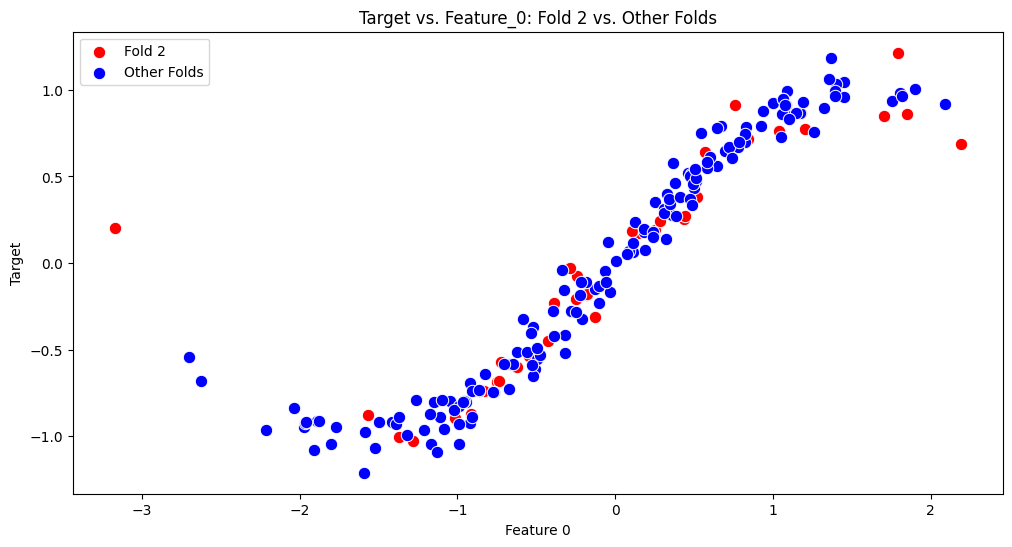

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

sns.scatterplot(data=df_fold2, x="feature_0", y="target", color='red', label="Fold 2", s=80)
sns.scatterplot(data=df_other, x="feature_0", y="target", color='blue', label="Other Folds", s=80)

plt.title("Target vs. Feature_0: Fold 2 vs. Other Folds")
plt.xlabel("Feature 0")
plt.ylabel("Target")
plt.legend()
plt.show()
